**Enhancing CIFAR-10 Image Classification with Deep Learning** <br>
Read doc about the CIFAR10 data. Create train and test datasets. Split the train set 50-50 into train and validation sets. Set the batch size to 64 and create dataloaders for train, validation and test sets. Get one batch of train samples and visualize them in a 8x8 grid.<br>
Train a multi-layer perceptron (MLP) to classify the CIFAR10 data. Use two hidden layers each with 64 neurons, ReLU activation, CrossEntropyLoss, SGD with learning rate=0.001 and momentum=0.9. Train your model for 20 epoches. Remember to save the best model based on validation accuracy at the end of each epoch. Book-keep train/validation loss/accuracy for all epoches. After training, evaluate the saved best model on the test set. Plot the train/validation loss/accuracy against epoch number. <br>
Change the optimizer to Adam. Compare the loss/accuracy curves with that of SGD. Discuss how the Adam optimizer changes the convergence speed and model performance.<br>
Add Dropout after hidden layers. Use the default dropout rate of 0.5. Discuss how Dropout changes the learning speed and model performance.<br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

# load CIFAR10 dataset
train_dataset = datasets.CIFAR10(
    './data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

100%|██████████| 170498071/170498071 [00:11<00:00, 14549338.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [2]:
# split the training dataset into training and validation sets 50-50
train_size = int(0.5 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [3]:
#create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=64, shuffle=False)

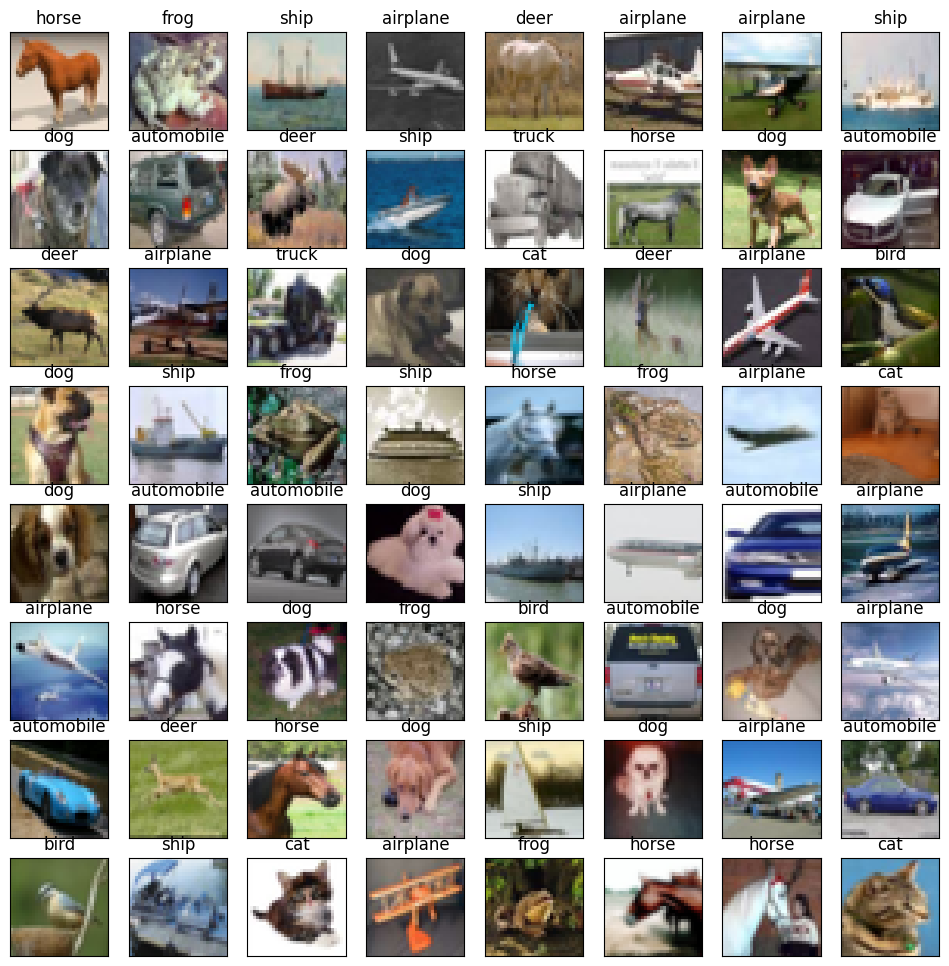

In [4]:
#get a batch of sample images and plot images in 8x8 grid

import matplotlib.pyplot as plt
import numpy as np

images,labels= next(iter(train_loader))
images,labels,images.shape,labels.shape
batch_size=64

classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def RGBshow(img):
    img=img*0.5+0.5 # unnormalized_sample=normalized_sample×std+mean
    plt.imshow(np.transpose(img,(1,2,0))) #permute the dimensions to channel-last format (Batch, H, W, C)

fig = plt.figure(1, figsize=(12, 12))  # 8x8 grid
for idx in range(batch_size):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    RGBshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [5]:
# batch of training samples
images,labels= next(iter(train_loader))

# shape of the data
print(f"Data shape: {images.shape}")

# basic statistics
print(f"Data min: {images.min()}, Data max: {images.max()}, Data mean: {images.mean()}, Data std: {images.std()}")

Data shape: torch.Size([64, 3, 32, 32])
Data min: -1.0, Data max: 1.0, Data mean: -0.09026411175727844, Data std: 0.5091743469238281


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define the MLP model with SGD optimizer
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 64) #input: 3*32*32
        self.fc2 = torch.nn.Linear(64,64) #first hidden layer 64 neurons
        self.fc3 = torch.nn.Linear(64,64)  #second hidden layer 64 neurons
        self.fc4 = nn.Linear(64, 10) #num of classes in cifar10: 10

    def forward(self,x):
        x = x.view(-1,32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x

In [7]:
# CIFAR10 already loaded above
# split training into train and val 50-50 as above
# train test and val loaders created above

# Initialize the model, loss function, and optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
model

MLP(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
def model_eval(model, loader_, criterion):
    # Test the model
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader_:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            eval_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    eval_loss /= len(loader_)
    eval_acc = correct/len(loader_.dataset)
    return eval_loss, eval_acc

In [11]:
import time
epochs = list(range(20))
train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []
epoch_times = []

# Train the model
model = model.to(device)
best_acc = 0
for epoch in range(20):
    start_time = time.time()  # Record the start time
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_acc = correct/len(train_loader.dataset)
    val_loss, val_acc = model_eval(model, val_loader, criterion)
    print('Train Epoch: {}\tLoss: {:.6f}\tAcc: {:.3f}'
          '\tVal - Loss:{:.6f}\tAcc:{:.3f}'.format(
              epoch, train_loss, train_acc, val_loss, val_acc))
    if val_acc > best_acc:
        torch.save(model.state_dict(), 'cifar10_best_model.pt')
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    end_time = time.time()  # Record the end time
    epoch_time = end_time - start_time  # Calculate the time taken for this epoch
    epoch_times.append(epoch_time)

# Print the time taken for each epoch
for epoch, time_taken in enumerate(epoch_times):
    print(f"Epoch {epoch + 1} took {time_taken:.2f} seconds.")

Train Epoch: 0	Loss: 2.302493	Acc: 0.113	Val - Loss:2.302172	Acc:0.117
Train Epoch: 1	Loss: 2.301932	Acc: 0.125	Val - Loss:2.301612	Acc:0.130
Train Epoch: 2	Loss: 2.301350	Acc: 0.136	Val - Loss:2.301017	Acc:0.139
Train Epoch: 3	Loss: 2.300720	Acc: 0.144	Val - Loss:2.300345	Acc:0.144
Train Epoch: 4	Loss: 2.299950	Acc: 0.146	Val - Loss:2.299473	Acc:0.150
Train Epoch: 5	Loss: 2.298887	Acc: 0.151	Val - Loss:2.298205	Acc:0.153
Train Epoch: 6	Loss: 2.297300	Acc: 0.158	Val - Loss:2.296254	Acc:0.157
Train Epoch: 7	Loss: 2.294793	Acc: 0.160	Val - Loss:2.293059	Acc:0.161
Train Epoch: 8	Loss: 2.290623	Acc: 0.161	Val - Loss:2.287593	Acc:0.162
Train Epoch: 9	Loss: 2.283720	Acc: 0.178	Val - Loss:2.278789	Acc:0.184
Train Epoch: 10	Loss: 2.275340	Acc: 0.180	Val - Loss:2.271107	Acc:0.185
Train Epoch: 11	Loss: 2.269572	Acc: 0.184	Val - Loss:2.266280	Acc:0.192
Train Epoch: 12	Loss: 2.265064	Acc: 0.194	Val - Loss:2.261840	Acc:0.202
Train Epoch: 13	Loss: 2.259824	Acc: 0.203	Val - Loss:2.255949	Acc:0.207
Tr

In [17]:
# Test the model
model.load_state_dict(torch.load('cifar10_best_model.pt'))
test_loss, test_acc = model_eval(model, test_loader, criterion)
print('Test - Loss:{:.6f}\tAcc:{:.3f}'.format(test_loss, test_acc))

Test - Loss:2.197608	Acc:0.244


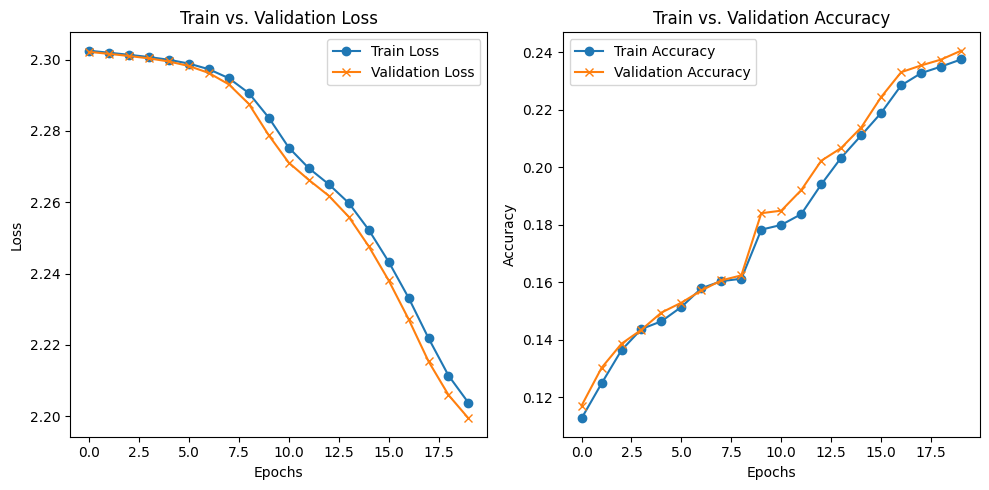

In [18]:
# plot train/validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_values, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs. Validation Loss')
plt.legend()

# plot train/validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_values, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
#Change the optimizer to Adam. Compare the loss/accuracy curves with that of SGD.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define the MLP model with Adam optimizer
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 64) #input: 3*32*32
        self.fc2 = torch.nn.Linear(64,64) #first hidden layer 64 neurons
        self.fc3 = torch.nn.Linear(64,64)  #second hidden layer 64 neurons
        self.fc4 = nn.Linear(64, 10) #num of classes in cifar10: 10

    def forward(self,x):
        x = x.view(-1,32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x

In [20]:
# CIFAR10 already loaded above
# split training into train and val 50-50 as above
# train test and val loaders created above

# Initialize the model, loss function, and optimizer Adam
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [21]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [22]:
model

MLP(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [23]:
def model_eval(model, loader_, criterion):
    # Test the model
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader_:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            eval_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    eval_loss /= len(loader_)
    eval_acc = correct/len(loader_.dataset)
    return eval_loss, eval_acc

In [24]:
import time
epochs = list(range(20))
train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []
epoch_times = []

# Train the model
model = model.to(device)
best_acc = 0
for epoch in range(20):
    start_time = time.time()  # Record the start time
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_acc = correct/len(train_loader.dataset)
    val_loss, val_acc = model_eval(model, val_loader, criterion)
    print('Train Epoch: {}\tLoss: {:.6f}\tAcc: {:.3f}'
          '\tVal - Loss:{:.6f}\tAcc:{:.3f}'.format(
              epoch, train_loss, train_acc, val_loss, val_acc))
    if val_acc > best_acc:
        torch.save(model.state_dict(), 'cifar10_best_model.pt')
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    end_time = time.time()  # Record the end time
    epoch_time = end_time - start_time  # Calculate the time taken for this epoch
    epoch_times.append(epoch_time)

# Print the time taken for each epoch
for epoch, time_taken in enumerate(epoch_times):
    print(f"Epoch {epoch + 1} took {time_taken:.2f} seconds.")

Train Epoch: 0	Loss: 2.134682	Acc: 0.319	Val - Loss:2.079061	Acc:0.377
Train Epoch: 1	Loss: 2.062712	Acc: 0.392	Val - Loss:2.051662	Acc:0.404
Train Epoch: 2	Loss: 2.037629	Acc: 0.419	Val - Loss:2.056490	Acc:0.398
Train Epoch: 3	Loss: 2.020968	Acc: 0.435	Val - Loss:2.044469	Acc:0.410
Train Epoch: 4	Loss: 2.001867	Acc: 0.456	Val - Loss:2.032586	Acc:0.424
Train Epoch: 5	Loss: 1.989549	Acc: 0.469	Val - Loss:2.022877	Acc:0.432
Train Epoch: 6	Loss: 1.975041	Acc: 0.483	Val - Loss:2.027108	Acc:0.429
Train Epoch: 7	Loss: 1.969307	Acc: 0.488	Val - Loss:2.017103	Acc:0.439
Train Epoch: 8	Loss: 1.963731	Acc: 0.495	Val - Loss:2.016017	Acc:0.440
Train Epoch: 9	Loss: 1.952924	Acc: 0.507	Val - Loss:2.027904	Acc:0.429
Train Epoch: 10	Loss: 1.945563	Acc: 0.513	Val - Loss:2.018541	Acc:0.439
Train Epoch: 11	Loss: 1.937176	Acc: 0.522	Val - Loss:2.007199	Acc:0.449
Train Epoch: 12	Loss: 1.929453	Acc: 0.529	Val - Loss:2.005815	Acc:0.452
Train Epoch: 13	Loss: 1.926366	Acc: 0.533	Val - Loss:2.001330	Acc:0.456
Tr

In [25]:
# Test the model with adam optimizer
model.load_state_dict(torch.load('cifar10_best_model.pt'))
test_loss, test_acc = model_eval(model, test_loader, criterion)
print('Test - Loss:{:.6f}\tAcc:{:.3f}'.format(test_loss, test_acc))

Test - Loss:1.998293	Acc:0.459


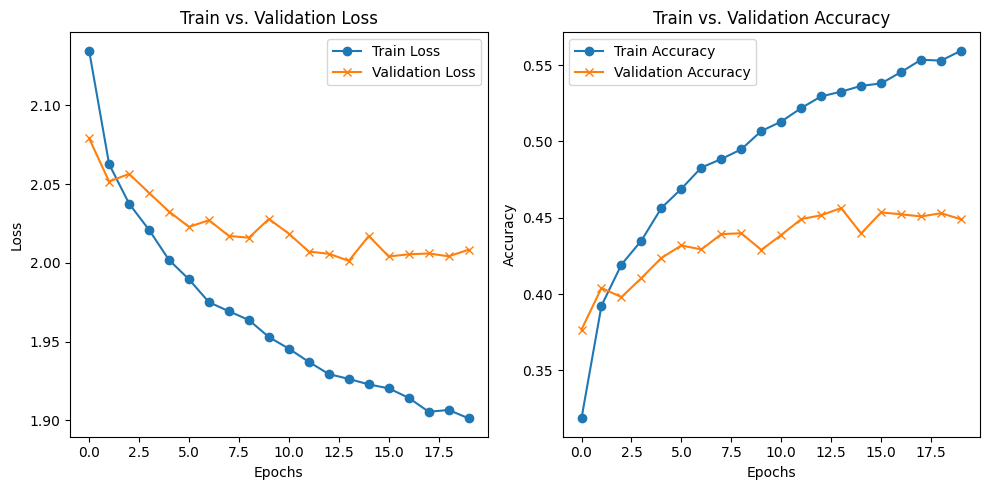

In [26]:
# plot train/validation loss for Adam optimizer
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_values, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs. Validation Loss')
plt.legend()

# plot train/validation accuracy for Adam optimizer
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_values, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
#Add Dropout after hidden layers. Use the default dropout rate of 0.5
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define the MLP model with dropout
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 64) #input: 3*32*32
        self.fc2 = torch.nn.Linear(64,64) #first hidden layer 64 neurons
        self.fc3 = torch.nn.Linear(64,64)  #second hidden layer 64 neurons
        self.fc4 = nn.Linear(64, 10) #num of classes in cifar10: 10
        self.dropout = nn.Dropout(p=0.5) #dropout rate: 0.5

    def forward(self,x):
        x = x.view(-1,32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.softmax(self.fc4(x), dim=1)
        return x

In [28]:
# CIFAR10 already loaded above
# split training into train and val 50-50 as above
# train test and val loaders created above

# Initialize the model, loss function, and optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [29]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [30]:
model

MLP(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [31]:
def model_eval(model, loader_, criterion):
    # Test the model
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader_:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            eval_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    eval_loss /= len(loader_)
    eval_acc = correct/len(loader_.dataset)
    return eval_loss, eval_acc

In [32]:
import time
epochs = list(range(20))
train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []
epoch_times = []

# Train the model
model = model.to(device)
best_acc = 0
for epoch in range(20):
    start_time = time.time()  # Record the start time
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_acc = correct/len(train_loader.dataset)
    val_loss, val_acc = model_eval(model, val_loader, criterion)
    print('Train Epoch: {}\tLoss: {:.6f}\tAcc: {:.3f}'
          '\tVal - Loss:{:.6f}\tAcc:{:.3f}'.format(
              epoch, train_loss, train_acc, val_loss, val_acc))
    if val_acc > best_acc:
        torch.save(model.state_dict(), 'cifar10_best_model.pt')
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    end_time = time.time()  # Record the end time
    epoch_time = end_time - start_time  # Calculate the time taken for this epoch
    epoch_times.append(epoch_time)

# Print the time taken for each epoch
for epoch, time_taken in enumerate(epoch_times):
    print(f"Epoch {epoch + 1} took {time_taken:.2f} seconds.")

Train Epoch: 0	Loss: 2.302472	Acc: 0.101	Val - Loss:2.302339	Acc:0.100
Train Epoch: 1	Loss: 2.302157	Acc: 0.108	Val - Loss:2.302062	Acc:0.106
Train Epoch: 2	Loss: 2.301853	Acc: 0.114	Val - Loss:2.301762	Acc:0.140
Train Epoch: 3	Loss: 2.301587	Acc: 0.118	Val - Loss:2.301412	Acc:0.162
Train Epoch: 4	Loss: 2.301374	Acc: 0.120	Val - Loss:2.300996	Acc:0.170
Train Epoch: 5	Loss: 2.300875	Acc: 0.127	Val - Loss:2.300434	Acc:0.175
Train Epoch: 6	Loss: 2.300340	Acc: 0.133	Val - Loss:2.299699	Acc:0.175
Train Epoch: 7	Loss: 2.299621	Acc: 0.140	Val - Loss:2.298663	Acc:0.173
Train Epoch: 8	Loss: 2.298494	Acc: 0.144	Val - Loss:2.297062	Acc:0.167
Train Epoch: 9	Loss: 2.296327	Acc: 0.148	Val - Loss:2.294107	Acc:0.161
Train Epoch: 10	Loss: 2.293051	Acc: 0.145	Val - Loss:2.288796	Acc:0.155
Train Epoch: 11	Loss: 2.287991	Acc: 0.144	Val - Loss:2.280882	Acc:0.154
Train Epoch: 12	Loss: 2.282965	Acc: 0.144	Val - Loss:2.273705	Acc:0.158
Train Epoch: 13	Loss: 2.277498	Acc: 0.147	Val - Loss:2.267779	Acc:0.166
Tr

In [33]:
# Test the model
model.load_state_dict(torch.load('cifar10_best_model.pt'))
test_loss, test_acc = model_eval(model, test_loader, criterion)
print('Test - Loss:{:.6f}\tAcc:{:.3f}'.format(test_loss, test_acc))

Test - Loss:2.236432	Acc:0.207


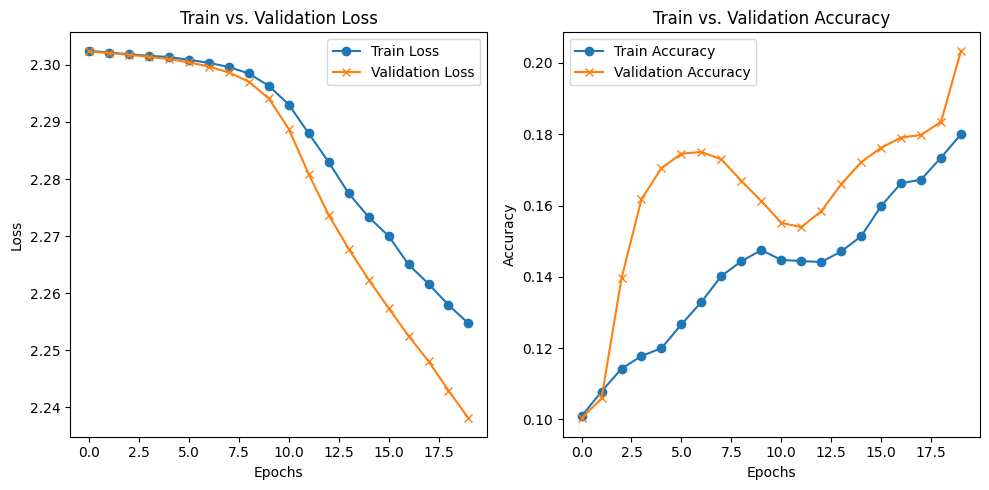

In [34]:
# plot train/validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_values, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs. Validation Loss')
plt.legend()

# plot train/validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_values, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()